In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

In [28]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.metrics import precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## 7. Máquina de Soporte Vectorial

In [3]:
df_final=pd.read_pickle("data_limpia.pkl") 

### 7.1 Modelo sin balanceo

In [4]:
X=df_final.drop(columns=['target'])
y=df_final['target']

In [5]:
y = y.map({
    'diseased': 1,
    'healthy': 0,
})

# Verificamos la codificación
print(y.value_counts())

target
0    70097
1    29903
Name: count, dtype: int64


In [6]:
numerical_cols=['age', 'bmi','waist_size',
    'blood_pressure', 'cholesterol', 'heart_rate',
    'glucose', 'insulin','sleep_hours','work_hours','physical_activity','daily_steps',
    'calorie_intake', 'sugar_intake','water_intake','income',
    'screen_time', 'stress_level', 'mental_health_score', 'meals_per_day']

cat_cols=['gender', 'diet_type', 'occupation',
    'sleep_quality', 'mental_health_support', 'exercise_type',
    'device_usage', 'healthcare_access', 'insurance',
    'family_history', 'sunlight_exposure', 'alcohol_consumption', 
    'smoking_level', 'education_level', 'job_type', 'caffeine_intake', 'pet_owner']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [ ]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("svm", LinearSVC(random_state=42))
])

# --- GRID DE PARÁMETROS ---
param_grid_pipe = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]
}



In [13]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1, verbose=1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tiempo de ejecucion(segundos):85.27


In [14]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'svm__C': 100}
Best cross-validation score: 0.19


In [18]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_scores = best_model.decision_function(X_test)
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.70      0.75      0.73     17524
    diseased       0.30      0.25      0.27      7476

    accuracy                           0.60     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.58      0.60      0.59     25000



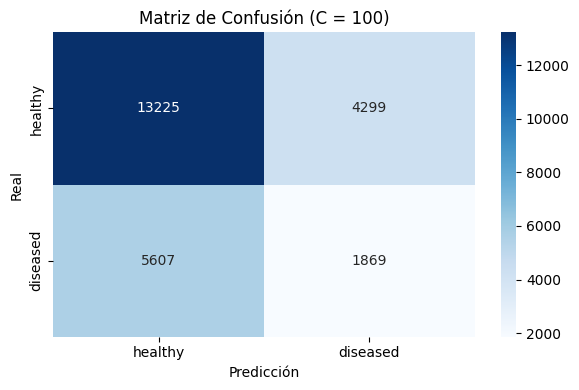

In [17]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

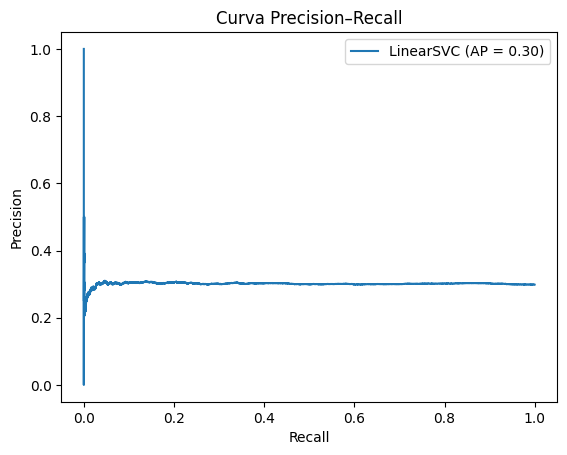

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular área bajo la curva (AP)
ap = average_precision_score(y_test, y_scores)

# Graficar
plt.figure()
plt.plot(recall, precision, label=f'LinearSVC (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision–Recall')
plt.legend()
plt.show()

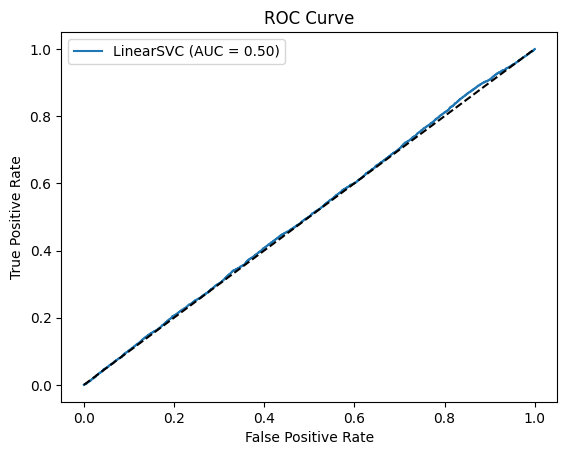

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure()
plt.plot(fpr, tpr, label=f'LinearSVC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### 7.2 Modelo con balanceo por el parámetro `class_weight='balanced'`

In [21]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("svm", LinearSVC(random_state=42, class_weight='balanced'))
])

# --- GRID DE PARÁMETROS ---
param_grid_pipe = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]
}



In [22]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1, verbose=1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tiempo de ejecucion(segundos):69.74


In [23]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'svm__C': 0.001}
Best cross-validation score: 0.49


In [24]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_scores = best_model.decision_function(X_test)
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.70      0.51      0.59     17524
    diseased       0.30      0.50      0.37      7476

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.48     25000
weighted avg       0.58      0.50      0.53     25000



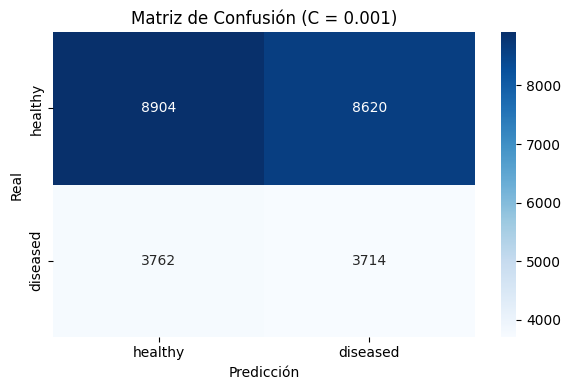

In [25]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

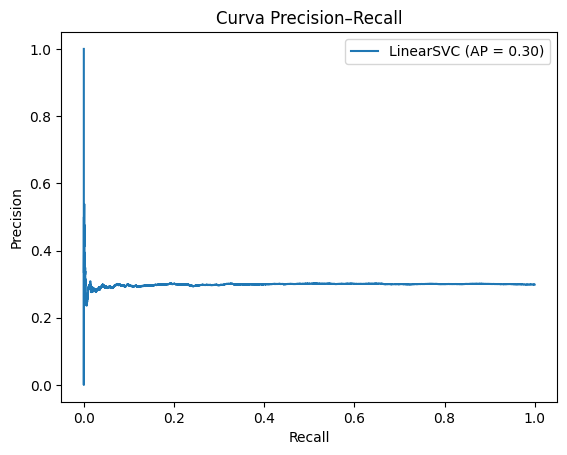

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular área bajo la curva (AP)
ap = average_precision_score(y_test, y_scores)

# Graficar
plt.figure()
plt.plot(recall, precision, label=f'LinearSVC (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision–Recall')
plt.legend()
plt.show()

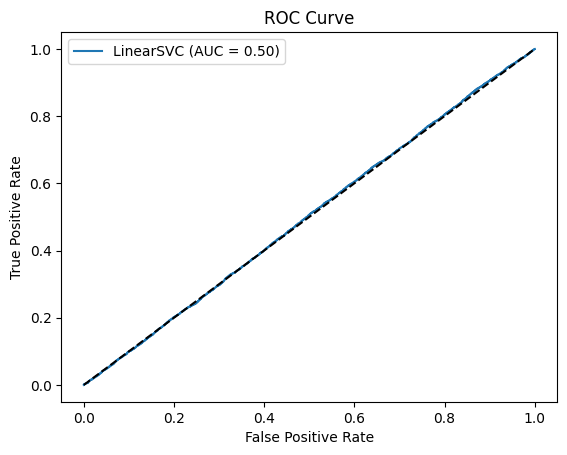

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure()
plt.plot(fpr, tpr, label=f'LinearSVC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### 7.3 Modelo con balanceo por el método `SMOTE`

In [48]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42, n_jobs=-1)),
    ("svm", LinearSVC(random_state=42))
])

# --- GRID DE PARÁMETROS ---
param_grid_pipe = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]
}


In [49]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1, verbose=1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tiempo de ejecucion(segundos):199.48


In [50]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'svm__C': 100}
Best cross-validation score: 0.62


In [51]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_scores = best_model.decision_function(X_test)
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))


 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.71      0.24      0.36     17524
    diseased       0.30      0.76      0.43      7476

    accuracy                           0.40     25000
   macro avg       0.50      0.50      0.40     25000
weighted avg       0.59      0.40      0.38     25000



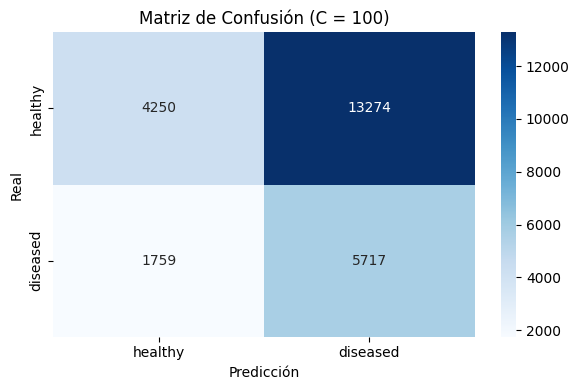

In [52]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

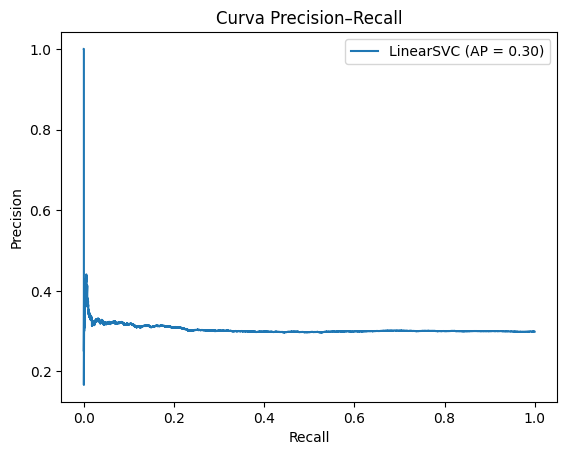

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular área bajo la curva (AP)
ap = average_precision_score(y_test, y_scores)

# Graficar
plt.figure()
plt.plot(recall, precision, label=f'LinearSVC (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision–Recall')
plt.legend()
plt.show()

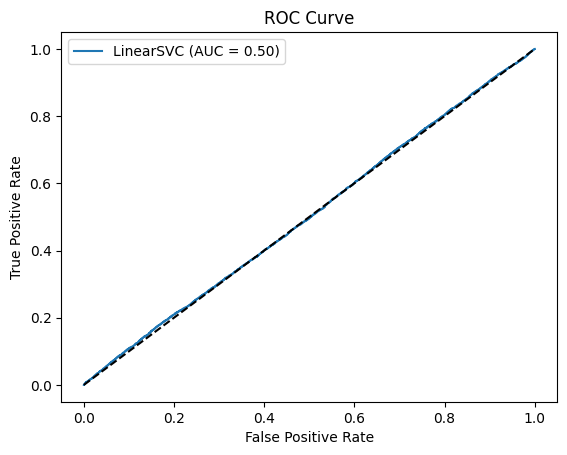

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure()
plt.plot(fpr, tpr, label=f'LinearSVC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### 7.4 Modelo con balanceo por el método `ADASYN`

In [55]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42, n_jobs=-1)),
    ("svm", LinearSVC(random_state=42))
])

# --- GRID DE PARÁMETROS ---
param_grid_pipe = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]
}


In [56]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1, verbose=1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tiempo de ejecucion(segundos):196.36


In [57]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'svm__C': 0.001}
Best cross-validation score: 0.83


In [58]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_scores = best_model.decision_function(X_test)
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.71      0.14      0.23     17524
    diseased       0.30      0.87      0.45      7476

    accuracy                           0.35     25000
   macro avg       0.50      0.50      0.34     25000
weighted avg       0.58      0.35      0.29     25000



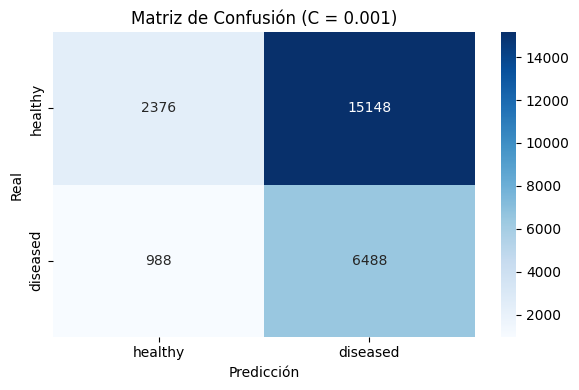

In [59]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

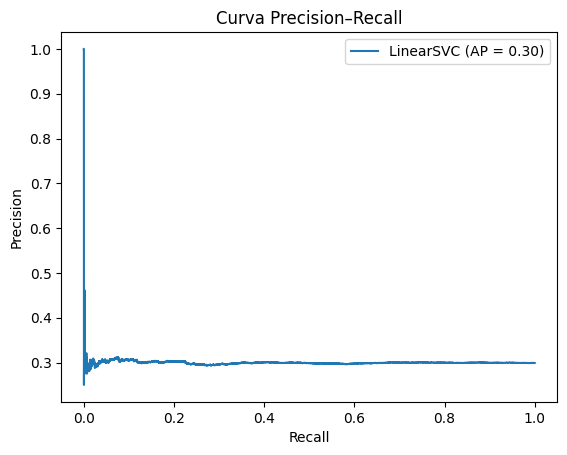

In [60]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular área bajo la curva (AP)
ap = average_precision_score(y_test, y_scores)

# Graficar
plt.figure()
plt.plot(recall, precision, label=f'LinearSVC (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision–Recall')
plt.legend()
plt.show()

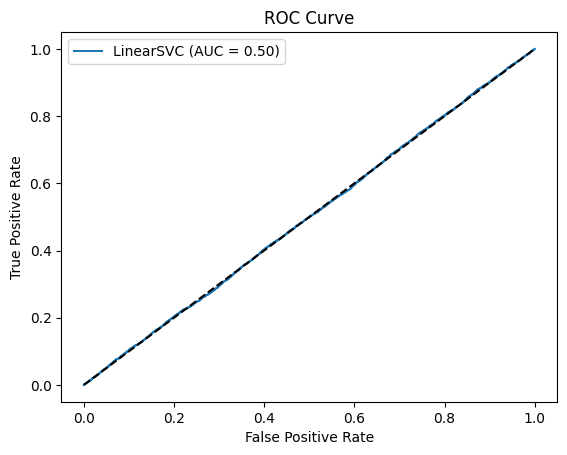

In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure()
plt.plot(fpr, tpr, label=f'LinearSVC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()